## TEXT DETECTION

In [2]:
# import modules
%matplotlib inline
import random
import pylab
import pandas as pd
import numpy as np
import cPickle as pkl
from PIL import Image
import matplotlib.pyplot as plt
from lasagne import layers
from lasagne.updates import nesterov_momentum
from theano.tensor.nnet import softmax
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import BatchIterator

Using gpu device 0: GeForce GT 740M (CNMeM is disabled)


### reading SVT

In [5]:
from sklearn.feature_extraction import image
patches = image.extract_patches(img, (20, 20, 3), extraction_step = (20, 20, 3))
patches.shape

(40, 64, 1, 20, 20, 3)

In [ ]:
#i = random.randrange(0, 751)
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        pylab.imshow(patches[i, j, 0, :, :, :])
        pylab.show()

In [7]:
from scipy.misc import imresize
new_lst = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        new_lst.append(imresize(patches[i, j, 0, :, :, :], (32, 32)))
        
print len(new_lst)

2560


In [8]:
new_list = np.stack(new_lst)
new_list = new_list.dot([0.299, 0.587, 0.144])
print new_list.shape
tester = new_list.reshape(patches.shape[0]*patches.shape[1], 1, 32, 32)

(2560, 32, 32)


In [9]:
tester /= tester.std(axis = None)
tester -= tester.mean()
tester = tester.astype('float32')

In [4]:
from scipy.misc import imread as ims
img = ims('/home/faizy/workspace/project/project/datasets/svt/svt1/img/01_15.jpg')
img.shape

(800, 1280, 3)

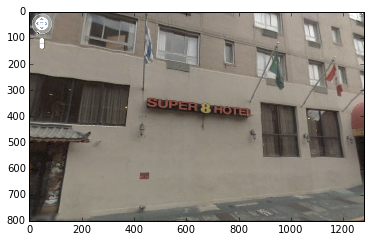

In [15]:
pylab.imshow(img)
pylab.show()

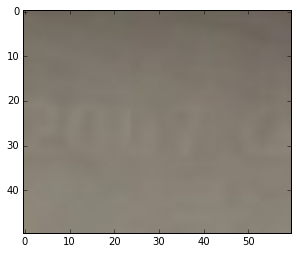

In [43]:
# visualize text
# S -> 316:375, 447:500
# U -> 326:385, 490:550
pylab.imshow(img[400:450, 490:550, :])
pylab.show()

In [44]:
tester = imresize(img[400:450, 490:550, :], (32, 32))
tester = tester.dot([0.299, 0.587, 0.144])
tester = tester.reshape(1, 1, 32, 32)

In [45]:
tester /= tester.std(axis = None)
tester -= tester.mean()
tester = tester.astype('float32')

In [12]:
#TODO implement a chars74k trained network
preder = netter.predict_proba(tester)

### reading chars74k

In [29]:
root = '/home/faizy/workspace/project/project/scripts'
data = pd.read_csv(root + '/LISTFILE.txt', sep = ' ', header = None)

In [70]:
print data.head(); print data.shape[0]

                                            0   1
0  Img/GoodImg/Bmp/Sample057/img057-00013.png  56
1  Img/GoodImg/Bmp/Sample057/img057-00028.png  56
2  Img/GoodImg/Bmp/Sample057/img057-00021.png  56
3  Img/GoodImg/Bmp/Sample057/img057-00022.png  56
4  Img/GoodImg/Bmp/Sample057/img057-00030.png  56
7705


In [35]:
from sklearn.cross_validation import train_test_split
train_x, test_x, train_y, test_y = train_test_split(data[0], data[1])

In [44]:
print train_x.head();print test_y.head(); print train_x.count()

7463    Img/GoodImg/Bmp/Sample041/img041-00142.png
864     Img/GoodImg/Bmp/Sample051/img051-00078.png
4922    Img/GoodImg/Bmp/Sample005/img005-00017.png
4426    Img/GoodImg/Bmp/Sample056/img056-00052.png
6970    Img/GoodImg/Bmp/Sample029/img029-00267.png
Name: 0, dtype: object
2020    10
3124    32
1989    10
3796    38
3284    29
Name: 1, dtype: int64
5778


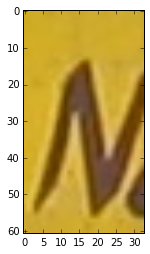

In [69]:
root = '/home/faizy/workspace/project/project/datasets/English/'
from scipy.misc import imread as ims
i = random.randrange(0, train_x.count())
img = ims(root + train_x.iloc[i])
pylab.imshow(img)
pylab.show()

### Actual code

In [2]:
# extra functions
def unpickle(filer):
    f = open(filer, 'rb')
    d_dict = pkl.load(f)
    f.close()
    return d_dict

from sklearn.cross_validation import train_test_split

In [3]:
# load train_test set
# cifar
train_dict = unpickle('/home/faizy/workspace/cifar/cifar-10-batches-py/data_batch_1')
train2_images = train_dict['data'].astype('float32')
train2_y = np.zeros((10000, )).astype('int')
test_dict = unpickle('/home/faizy/workspace/cifar/cifar-10-batches-py/test_batch')
test2_images = test_dict['data'].astype('float32')

# chars74k
data = pd.read_csv('/home/faizy/workspace/project/project/scripts/LISTFILE.txt', sep = ' ', header = None)
root = '/home/faizy/workspace/project/project/datasets/English/'
data_x = np.zeros((data.shape[0], 1, 32, 32))
data_y = np.ones((data.shape[0], )).astype('int32')
from scipy.misc import imread, imresize
for idx, path in enumerate(data[0]):
    img = imread(root + path)
    img = imresize(img, (32, 32))
    if len(img.shape) == 3:
        data_x[idx, ...] = img.dot([0.299, 0.587, 0.144])
    else:
        data_x[idx, ...] = img
        
data_x = data_x.astype('float32')
train1_x, test1_x, train1_y, test1_y = train_test_split(data_x, data_y, test_size = 0.2)

In [73]:
train1_x.shape, test1_x.shape

((6164, 1, 32, 32), (1541, 1, 32, 32))

In [4]:
# preprocess
# cifar
train2_images /= train2_images.std(axis = None)
train2_images -= train2_images.mean()

test2_images /= test2_images.std(axis = None)
test2_images -= test2_images.mean()

# chars74k
train1_x /= train1_x.std(axis = None)
train1_x -= train1_x.mean()

test1_x /= test1_x.std(axis = None)
test1_x -= test1_x.mean()

In [5]:
# reshape dataset
# cifar
# grayscaling and cropping to size
train2_x_rgb = train2_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

train2_x = np.zeros((10000, 1, 32, 32))
for i in range(10000):
    train2_x[i, :, :, :] = np.dot(train2_x_rgb[i, :, :, :], [0.299, 0.587, 0.144])

test2_x_rgb = test2_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

test2_x = np.zeros((10000, 1, 32, 32))
for i in range(10000):
    test2_x[i, :, :, :] = np.dot(test2_x_rgb[i, :, :, :], [0.299, 0.587, 0.144])

In [6]:
# finally
train_x = np.vstack((train1_x, train2_x))

train_y = np.concatenate([train1_y, train2_y])

test_x = np.vstack((test1_x, test2_x))

test_y = np.concatenate([test1_y, np.zeros((10000,))])

#TODO shuffle train-test

In [7]:
# check again
train_x = train_x.astype('float32')
train_y = train_y.astype('int32')
test_x = test_x.astype('float32')
test_y = test_y.astype('int32')

In [8]:
# setting nn 
net = NeuralNet(
    layers = [
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        ('conv3', layers.Conv2DLayer),
        ('hidden4', layers.DenseLayer),
        ('output', layers.DenseLayer),
    ],

    input_shape = (None, 1, 32, 32),
    conv1_num_filters = 32, conv1_filter_size = (5, 5),
    pool1_pool_size = (2, 2),
    dropout1_p = 0.2,
    conv2_num_filters = 64, conv2_filter_size = (5, 5),
    pool2_pool_size = (2, 2),
    dropout2_p = 0.2,
    conv3_num_filters = 128, conv3_filter_size = (5, 5),
    hidden4_num_units = 128,
    output_num_units = 2, output_nonlinearity = softmax,

    batch_iterator_train = BatchIterator(batch_size = 1000),
    batch_iterator_test = BatchIterator(batch_size = 1000),

    update=nesterov_momentum,
    update_learning_rate = 0.003,
    update_momentum = 0.9,

    use_label_encoder = True,
    regression = False,
    max_epochs = 50,
    verbose = 1,
)

In [9]:
# train and test nn
net.fit(train_x, train_y)
pred = net.predict(test_x)

# Neural Network with 273794 learnable parameters

## Layer information

  #  name      size
---  --------  --------
  0  input     1x32x32
  1  conv1     32x28x28
  2  pool1     32x14x14
  3  dropout1  32x14x14
  4  conv2     64x10x10
  5  pool2     64x5x5
  6  dropout2  64x5x5
  7  conv3     128x1x1
  8  hidden4   128
  9  output    2

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       0.79128       0.66980      1.18136      0.69150  13.84s
      2       0.66188       0.63928      1.03535      0.69175  12.59s
      3       0.66947       0.62711      1.06755      0.69175  12.38s
      4       0.67260       0.62087      1.08332      0.69175  12.35s
      5       0.67158       0.61619      1.08990      0.69175  12.34s
      6       0.66845       0.61134      1.09342      0.69175  12.35s
      7       0.66461       0.60546      1.09769      0.69175  12.34s
      8       0.66058       0.598

In [12]:
# Saving model
f = open('/home/faizy/workspace/project/project/models/detector.pkl', 'wb')
model = pkl.dump(net, f)
f.close()

In [10]:
# Load model
f = open('/home/faizy/workspace/project/project/models/detector.pkl', 'rb')
netter = pkl.load(f)
f.close()

--------------
It is a character


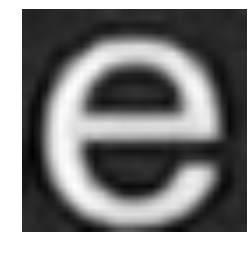

In [85]:
# visualize output
%matplotlib inline
i = random.randrange(0, test1_x.shape[0])
img = test_x[i, :]
img = img.reshape(32, 32)
pylab.imshow(img)
pylab.gray()
pylab.axis('off')
print '--------------'
if pred[i] == 1:
    print "It is a character"
else:
    print "It is NOT a character"

--------------
It is NOT a character


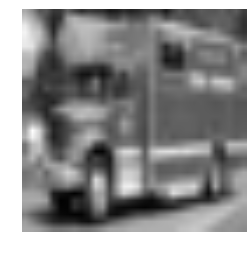

In [93]:
# visualize output
%matplotlib inline
i = random.randrange(test1_x.shape[0], test1_x.shape[0] + test2_x.shape[0])
img = test_x[i, :]
img = img.reshape(32, 32)
pylab.imshow(img)
pylab.gray()
pylab.axis('off')
print '--------------'
if pred[i] == 1:
    print "It is a character"
else:
    print "It is NOT a character"

In [10]:
from sklearn.metrics import accuracy_score, classification_report

In [11]:
print classification_report(test_y, pred)

             precision    recall  f1-score   support

          0       0.96      0.97      0.96     10000
          1       0.79      0.72      0.75      1541

avg / total       0.93      0.94      0.94     11541



In [ ]:
test_x.shape

In [ ]:
test1_x.shape

In [158]:
preder.shape

(36995,)

In [ ]:
for i, j in enumerate(preder):
    #if j == 1:
        pylab.imshow(tester[i, :, :].reshape(32, 32))
        pylab.show()

In [137]:
tester[i, :, :].reshape(32, 32).shape

(32, 32)

In [19]:
heatmap = preder[:, 0].reshape((patches.shape[0], patches.shape[1]))
print heatmap.shape

(40, 64)


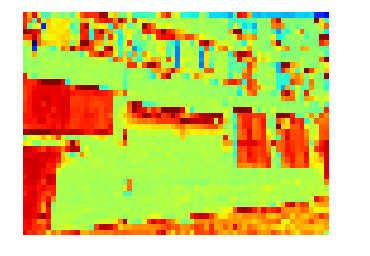

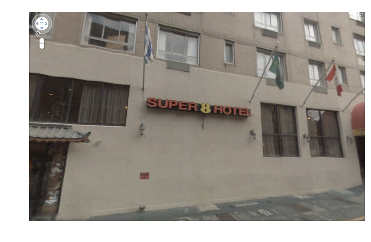

In [20]:
pylab.pcolor(heatmap[::-1])
pylab.axis('off')
pylab.show()
pylab.imshow(img)
pylab.axis('off')
pylab.show()

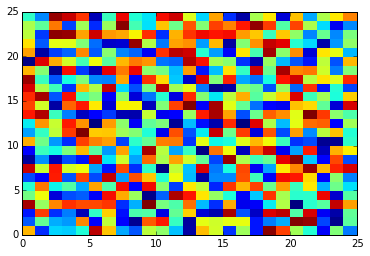

In [69]:
import pylab as pl
data = pl.random((25,25)) # 25x25 matrix of values
pl.pcolor(data)
pl.show()